In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import tensorflow as tf
import os,cv2
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
def set_seed(seed=200):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 9.5 MB/s 


In [ ]:
import keras_tuner as kt

In [ ]:
#Veritabanına baglanma
data_path = '/content/drive/MyDrive/OrjinalVeri'
data_dir_list = os.listdir(data_path)

In [ ]:
train_dir = data_path 
# Veri üretimi için parametreleri/argümanları belirtin
img_size = (48, 48)
batch_size = 64

In [ ]:
img_data_list=[] #bir liste oluşturuyoruz.
for dataset in data_dir_list:#Veritabanı
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        #input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)#Resim üzerinde işlemler
        input_img_resize=cv2.resize(input_img,img_size)
        img_data_list.append(input_img_resize)
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

Loaded the images of dataset-anger

Loaded the images of dataset-contempt

Loaded the images of dataset-disgust

Loaded the images of dataset-fear

Loaded the images of dataset-happy

Loaded the images of dataset-neutral

Loaded the images of dataset-sad

Loaded the images of dataset-surprise



(41553, 48, 48, 3)

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
num_classes = 8

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:5500]=0 #5500
labels[5501:9750]=1 #4250
labels[9751:14053]=2 #4303
labels[14054:19553]=3 #5500
labels[19554:25053]=4 #5500
labels[25054:30553]=5 #5500
labels[30554:36053]=6 #5500
labels[36054:41553]=7 #5500
names = ['anger','contempt','disgust','fear','happy','neutral','sadness','surprise']

def getLabel(id):
    return ['anger','contempt','disgust','fear','happy','neutral','sadness','surprise'][id]

Y = np_utils.to_categorical(labels, num_classes)
train_ratio = 0.64
test_ratio = 0.20
validation_ratio = 0.16

#Veri kümesini karıştır
X,y = shuffle(img_data,Y, random_state=2)
# Veri kümesini böl
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=validation_ratio/(train_ratio+test_ratio))

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(26910, 48, 48, 3)
(8311, 48, 48, 3)
(6332, 48, 48, 3)


In [ ]:
print("X_Train shape {}".format(X_train.shape))
print("X_Test shape {}".format(X_test.shape))

X_Train shape (26910, 48, 48, 3)
X_Test shape (8311, 48, 48, 3)


In [ ]:
emotion_labels = ['anger','contempt','disgust','fear','happy','neutral','sadness','surprise']

In [ ]:
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

imgen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.15,
    horizontal_flip=False,
    vertical_flip=False
)

In [ ]:
imgen_valid = ImageDataGenerator()

imgen_train.fit(X_train)
imgen_valid.fit(X_test)

In [ ]:
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
chk_path = 'ferNet.h5'
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=5, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=5, 
                              verbose=1, 
                               min_lr=0.001)


callbacks = [earlystop, reduce_lr,checkpoint]

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
mobilenet_weights_path='/content/drive/MyDrive/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5'

In [ ]:
def build_model(hp):
    
    model = keras.Sequential([   
    keras.layers.Conv2D(64,3,activation=hp.Choice("activation", ["relu", "elu"]),padding='same',input_shape=(48,48,3)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=hp.Float("dropout_",min_value=0.2,max_value=0.5,step=0.1)),
    # adding second convolutional layer 
    keras.layers.Conv2D(128,3,activation=hp.Choice("activation", ["relu", "elu"]),padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(3,2),
    keras.layers.Dropout(rate=hp.Float("dropout_",min_value=0.2,max_value=0.5,step=0.1)),

    keras.layers.Conv2D(128,3,activation=hp.Choice("activation", ["relu", "elu"]),padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=hp.Float("dropout_",min_value=0.2,max_value=0.5,step=0.1)),
    
    keras.layers.Conv2D(256,3,activation=hp.Choice("activation", ["relu", "elu"]),padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(3),
    keras.layers.Dropout(rate=hp.Float("dropout_",min_value=0.2,max_value=0.5,step=0.1)),
    
    keras.layers.Conv2D(512,3,activation=hp.Choice("activation", ["relu", "elu"]),padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.GlobalMaxPooling2D(),
    keras.layers.Dropout(rate=hp.Float("dropout_",min_value=0.2,max_value=0.5,step=0.1)),

    # adding flatten layer    
    keras.layers.Flatten(),
    # adding dense layer    
    keras.layers.Dense(512, activation=hp.Choice("activation", ["relu", "elu"])),
    keras.layers.Dropout(rate=hp.Float("dropout_",min_value=0.2,max_value=0.5,step=0.1)),
    keras.layers.Dense(512, activation=hp.Choice("activation", ["relu", "elu"])),
    keras.layers.Dropout(rate=hp.Float("dropout_",min_value=0.2,max_value=0.5,step=0.1)),
    keras.layers.Dense(512, activation=hp.Choice("activation", ["relu", "elu"])),
    keras.layers.Dropout(rate=hp.Float("dropout_",min_value=0.2,max_value=0.5,step=0.1)),
    keras.layers.BatchNormalization(),

    # output layer    
    keras.layers.Dense(8, activation='softmax')
    ])
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    #compilation of model
    optimizer=hp.Choice('optimizer',['adam','RMSprop'])
    if hp.Choice('optimizer',['adam','RMSprop'])=='adam':
      model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    else:
      model.compile(
          optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
          loss="categorical_crossentropy",
          metrics=["accuracy"],
      )
    
    return model

In [ ]:
import keras_tuner as kt
from tensorflow.keras import layers
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], 'ordered': False}
dropout_ (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001, 1e-05], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'RMSprop'], 'ordered': False}


In [ ]:
EPOCHS = 50 
BATCH = 64
tuner.search(
    imgen_train.flow(*shuffle(X_train, y_train), batch_size=BATCH),
    steps_per_epoch=X_train.shape[0]//(4*BATCH),
    epochs=EPOCHS,
    validation_data=imgen_valid.flow(*shuffle(X_test, y_test)),
    validation_steps=BATCH)

Trial 30 Complete [00h 02m 26s]
val_accuracy: 0.14111328125

Best val_accuracy So Far: 0.16943359375
Total elapsed time: 00h 35m 05s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in my_dir/intro_to_kt
Showing 10 best trials
Trial summary
Hyperparameters:
activation: elu
dropout_: 0.5000000000000001
learning_rate: 0.001
optimizer: RMSprop
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.16943359375
Trial summary
Hyperparameters:
activation: relu
dropout_: 0.30000000000000004
learning_rate: 0.001
optimizer: adam
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.16455078125
Trial summary
Hyperparameters:
activation: elu
dropout_: 0.4000000000000001
learning_rate: 0.0001
optimizer: adam
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.1591796875
Trial summary
Hyperparameters:
activation: elu
dropout_: 0.30000000000000004
learning_rate: 0.0001
optimizer: adam
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.158203125
Trial summary
Hyperparameters:
activation: relu
dropout_: 0.30000000000000004
learning_rate: 0.001
opti

In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model = tuner.hypermodel.build(best_hp)

In [ ]:
EPOCHS = 50 
BATCH = 64

history = model.fit_generator(
    imgen_train.flow(*shuffle(X_train, y_train), batch_size=BATCH),
    steps_per_epoch=X_train.shape[0]//(4*BATCH),
    epochs=EPOCHS,
    validation_data=imgen_valid.flow(*shuffle(X_test, y_test)),
    validation_steps=BATCH
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


105/105 [==============================] - 15s 121ms/step - loss: 2.6380 - accuracy: 0.1317 - val_loss: 2.0998 - val_accuracy: 0.1367
Epoch 2/50
105/105 [==============================] - 12s 118ms/step - loss: 2.4401 - accuracy: 0.1284 - val_loss: 2.0853 - val_accuracy: 0.1274
Epoch 3/50
105/105 [==============================] - 12s 117ms/step - loss: 2.3408 - accuracy: 0.1232 - val_loss: 2.0731 - val_accuracy: 0.1528
Epoch 4/50
105/105 [==============================] - 12s 117ms/step - loss: 2.2590 - accuracy: 0.1272 - val_loss: 2.0841 - val_accuracy: 0.1431
Epoch 5/50
105/105 [==============================] - 12s 117ms/step - loss: 2.2102 - accuracy: 0.1290 - val_loss: 2.1535 - val_accuracy: 0.1475
Epoch 6/50
105/105 [==============================] - 12s 116ms/step - loss: 2.1600 - accuracy: 0.1354 - val_loss: 2.1287 - val_accuracy: 0.1353
Epoch 7/50
105/105 [==============================] - 12s 116ms/step - loss: 2.1475 - accuracy: 0.1272 - val_loss: 2.0774 - val_accuracy: 0.1

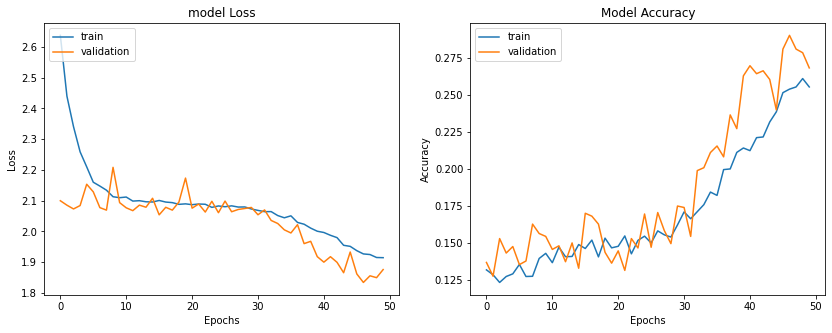

In [ ]:
Epochs=50
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#test başarısı
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Test Accuracy: 27.807%


In [ ]:
from sklearn.metrics import accuracy_score
test_true = np.argmax(y_test, axis=1)
test_pred = np.argmax(model.predict(X_test), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

CNN Model Accuracy on test set: 0.2781


In [ ]:
from sklearn.metrics import accuracy_score
test_true = np.argmax(y_test, axis=1)
test_pred = np.argmax(model.predict(X_test), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

CNN Model Accuracy on test set: 0.2781


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
  
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Hesaplama karışıklık matrisi
    cm = confusion_matrix(y_true, y_pred)
    # Yalnızca verilerde görünen etiketleri kullanın
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

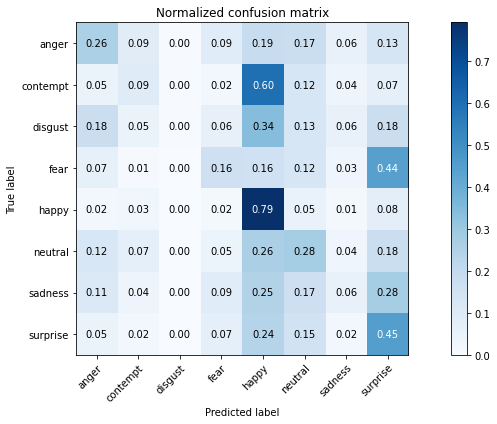

In [ ]:
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
target_names=emotion_labels
print(classification_report(test_true, test_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

       anger     0.3296    0.2622    0.2920      1110
    contempt     0.1966    0.0945    0.1276       847
     disgust     0.2143    0.0036    0.0071       827
        fear     0.3017    0.1648    0.2132      1098
       happy     0.3097    0.7920    0.4453      1130
     neutral     0.2409    0.2804    0.2592      1084
     sadness     0.2097    0.0610    0.0945      1132
    surprise     0.2534    0.4506    0.3244      1083

    accuracy                         0.2781      8311
   macro avg     0.2570    0.2636    0.2204      8311
weighted avg     0.2603    0.2781    0.2304      8311



In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_true, test_pred)

0.2780652147755986

# Yeni Bölüm

In [ ]:
EPOCHS = 50 
BATCH = 64

history = model.fit_generator(
    imgen_train.flow(*shuffle(X_train, y_train), batch_size=BATCH),
    steps_per_epoch=X_train.shape[0]//(4*BATCH),
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=imgen_valid.flow(*shuffle(X_test, y_test)),
    validation_steps=BATCH
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


105/105 [==============================] - ETA: 0s - loss: 1.8940 - accuracy: 0.2673
Epoch 1: val_loss improved from inf to 1.78335, saving model to ferNet.h5
105/105 [==============================] - 16s 156ms/step - loss: 1.8940 - accuracy: 0.2673 - val_loss: 1.7833 - val_accuracy: 0.2944 - lr: 0.0010
Epoch 2/50
105/105 [==============================] - ETA: 0s - loss: 1.8872 - accuracy: 0.2680
Epoch 2: val_loss did not improve from 1.78335
105/105 [==============================] - 12s 116ms/step - loss: 1.8872 - accuracy: 0.2680 - val_loss: 1.7961 - val_accuracy: 0.3071 - lr: 0.0010
Epoch 3/50
105/105 [==============================] - ETA: 0s - loss: 1.8733 - accuracy: 0.2732
Epoch 3: val_loss did not improve from 1.78335
105/105 [==============================] - 12s 116ms/step - loss: 1.8733 - accuracy: 0.2732 - val_loss: 1.8088 - val_accuracy: 0.3018 - lr: 0.0010
Epoch 4/50
105/105 [==============================] - ETA: 0s - loss: 1.8744 - accuracy: 0.2865
Epoch 4: val_loss 

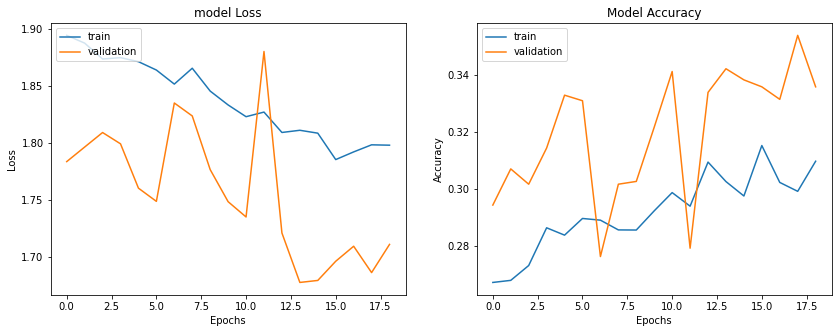

In [ ]:
Epochs=50
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#test başarısı
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Test Accuracy: 34.316%


In [ ]:
from sklearn.metrics import accuracy_score
test_true = np.argmax(y_test, axis=1)
test_pred = np.argmax(model.predict(X_test), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

CNN Model Accuracy on test set: 0.3432


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
  
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Hesaplama karışıklık matrisi
    cm = confusion_matrix(y_true, y_pred)
    # Yalnızca verilerde görünen etiketleri kullanın
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

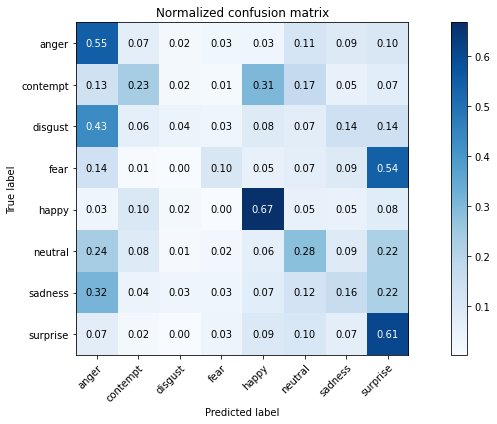

In [ ]:
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
target_names=emotion_labels
print(classification_report(test_true, test_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

       anger     0.3107    0.5477    0.3965      1110
    contempt     0.3333    0.2349    0.2756       847
     disgust     0.2406    0.0387    0.0667       827
        fear     0.4014    0.1020    0.1627      1098
       happy     0.5287    0.6681    0.5903      1130
     neutral     0.2995    0.2832    0.2911      1084
     sadness     0.2382    0.1599    0.1913      1132
    surprise     0.3086    0.6076    0.4093      1083

    accuracy                         0.3432      8311
   macro avg     0.3326    0.3303    0.2979      8311
weighted avg     0.3360    0.3432    0.3068      8311



In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_true, test_pred)

0.3431596679099988